In [1]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import utils
from torch.utils.data import DataLoader
import tqdm as tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from utils import load_csv, drop_cols, remove_strings, groupedAvg, subsample, normalize
from create_dataset import AnimalDataset, AnimalDatasetEmbedding
from generators import EmbeddingEncoderDecoderGenerator, EmbeddingUnetGenerator
from discriminators import MultiChannelDiscriminator 

/home/johann/anaconda3/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
# config

ALLDATA = True # if False -> smaller dataset
SKIPCONNECTIONS = True
EMBEDDING = True

DISCRIMINATOR = MultiChannelDiscriminator
GENERATOR = EmbeddingUnetGenerator

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 512  
LEARNING_RATE = 1e-4  # 1e-5 was too small for 'LVtot_kalibriert' and 'LVtot' 
NUM_WORKERS = 10
NUM_EPOCHS = 400
LR_DECAY_AFTER_EPOCH = 400  
GENERATION_AFTER_EPOCH = NUM_EPOCHS # number of epochs after which the model generates a sample
SIG_A = "AoP"           # Drucksignal Hauptschlagader = Aortendruck
SIG_B = "VADcurrent"    # VAD Strom [A] – Pumpemstrom in Ampere
SIG_C = "VadQ"          # Fluss durch VAD (VAD = Ventrikular assistance device = Pumpe) = Pumpenfluss
SIG_D = "LVP"           # Ventrikeldruck links = Drucksignal der linken Herzkammer
TARGET = "LVtot_kalibriert"
source_signals = [SIG_A, SIG_C, SIG_D]
CHANNELS = len(source_signals)
WINDOW = 256
# target = TARGET

# Use adversarial loss
GAN_LOSS = True   # adversarial loss
LAMBDA_GAN = 1.0
# Use cycle consistency loss
CYCLE = True
LAMBDA_CYCLE = 1.0
# Use supervised loss
SUPERVISED = False 
LAMBDA_SUPERVISED = 1.0
# Use Identity loss
IDENTITY = False
LAMBDA_IDENTITY = 10.0

In [3]:
# def load_df(path):
#     df = utils.load_csv(path)
#     df = utils.drop_cols(df)
#     df = df.dropna()
#     return df

# def load_data(alldata=ALLDATA):
#     if not alldata:
#         path = "/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/LeRntVAD_csv_exports_not_all_the_data/constant_speed_interventions/" 
#         df = load_df(path)
#         print(df.shape)
#         df = utils.remove_strings(df)
#         df = utils.subsample(df, 10)
#         print(df.shape)
#         return df

#     else:
#         path_1 = "/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/csv_export_files_alle_Daten/csv_export_files/Data_split_1"  
#         path_2 = "/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/csv_export_files_alle_Daten/csv_export_files/Data_split_2"
#         # path_3 = "/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/csv_export_files_alle_Daten/csv_export_files/Data_split_3"
#         # path_4 = "/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/csv_export_files_alle_Daten/csv_export_files/Data_split_4"
        
#         df_1 = load_csv(path_1)
#         df_2 = load_csv(path_2)
#         # df_3 = load_csv(path_3)
#         # df_4 = load_csv(path_4)
#         df = pd.concat([df_1, df_2], axis=0, ignore_index=True)

#         print(df.shape)
#         df = utils.remove_strings(df)
#         df = utils.subsample(df, 10)
#         print(df.shape)
#         return df

# df = load_data(alldata=ALLDATA)

In [4]:
# if ALLDATA == False:
#     # load only a small part of the data and drop the unnecessary columns
#     # paths of only a small part of the data
#     path = "/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/LeRntVAD_csv_exports_not_all_the_data/constant_speed_interventions/" 
#     df = utils.load_csv(path)
#     df = utils.drop_cols(df)
#     df = df.dropna()

#     # select only rows where 'Phasenzuordnung' is 1
#     # df = df.loc[df['Phasenzuordnung'] == 1]

#     print(df.shape) 

In [5]:
if ALLDATA == True:
    # Load all the data and drop unnecessary columns
    # We load the data separately, to avoid a Runtime error

    # all the data
    path_1 = "/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/csv_export_files_alle_Daten/csv_export_files/Data_split_1"  
    path_2 = "/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/csv_export_files_alle_Daten/csv_export_files/Data_split_2"
    path_3 = "/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/csv_export_files_alle_Daten/csv_export_files/Data_split_3"
    path_4 = "/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/csv_export_files_alle_Daten/csv_export_files/Data_split_4"

    df_1 = utils.load_csv(path_1)
    df_1 = utils.drop_cols(df_1)

    df_2 = utils.load_csv(path_2)
    df_2 = utils.drop_cols(df_2)

    # df_3 = utils.load_csv(path_3)
    # df_3 = utils.drop_cols(df_3)

    df_4 = utils.load_csv(path_4)
    df_4 = utils.drop_cols(df_4)

    # concatenate the separate dataframes
    df = pd.concat([df_1, df_2, df_4], axis=0, ignore_index=True)
    df = df.dropna()

    print('Size of the whole dataset',df.shape)
    # select only rows where 'Phasenzuordnung' is 1
    # df = df.loc[df['Phasenzuordnung'] == 1]
    # print('Size of dataset with only the first phase',df.shape)

Size of the whole dataset (41183412, 13)


In [6]:
df = utils.remove_strings(df)
df = utils.subsample(df, 10)

In [7]:
# import os


# def load_df(path):
#     df = utils.load_csv(path)
#     df = utils.drop_cols(df)
#     df = df.dropna()
#     return df


# if ALLDATA == True:
#     # Load all the data and drop unnecessary columns
#     # We load the data separately, to avoid a Runtime error

#     # all the data
#     base_path = "/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/csv_export_files_alle_Daten/csv_export_files/"
#     paths = [os.path.join(base_path, f"Data_split_{i}") for i in range(1, 5)]

#     df = pd.concat([load_df(path) for path in paths], axis=0, ignore_index=True)
    
#     print('Size of the whole dataset',df.shape)
#     # select only rows where 'Phasenzuordnung' is 1
#     # df = df.loc[df['Phasenzuordnung'] == 1]
#     # print('Size of dataset with only the first phase',df.shape)
# else:
#     # load only a small part of the data and drop the unnecessary columns
#     # paths of only a small part of the data
#     path = "/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/LeRntVAD_csv_exports_not_all_the_data/constant_speed_interventions/" 

#     df = load_df(path)

#     # select only rows where 'Phasenzuordnung' is 1
#     # df = df.loc[df['Phasenzuordnung'] == 1]

#     print(df.shape) 

In [8]:
print(df['animal'].unique())
# remove animals with less than 10 data points
df = df.groupby('animal').filter(lambda x: len(x) > 10)
df['animal'].unique()

[  8   7   4   2   5   3   6   1  12  13  11  10   9  60 108 105 111 110
  64  20  29 113  94  28 102  77  85  72  54 104  80 107  19  66 101 103
  38  90 112  46  79  37  57  45  55  44  88  75  84  61]


array([  8,   7,   4,   2,   5,   3,   1,  12,  13,  11,  10,   9, 108,
       105, 111,  20, 113, 102, 107,  19, 101])

In [9]:
def normalize_by_phase1(df, scaler):
    '''
    Normalize the data by the first phase
    '''
    # column names
    cols = df.columns.tolist()
    # select data von Phasenzuordnung == 1
    phase_1 = df.loc[df['Phasenzuordnung'] == 1]
    phase_1 = phase_1.to_numpy() 
    df = df.to_numpy()  #convert to numpy
    # scale the data only with the first phase
    scaler.fit(phase_1)
    transformed_data = scaler.transform(df)
    df = pd.DataFrame(transformed_data, columns=cols)  # convert to dataframe
    # df = df.join(df_IPA) 
    return df

(4118283, 13)
(4118283, 13)


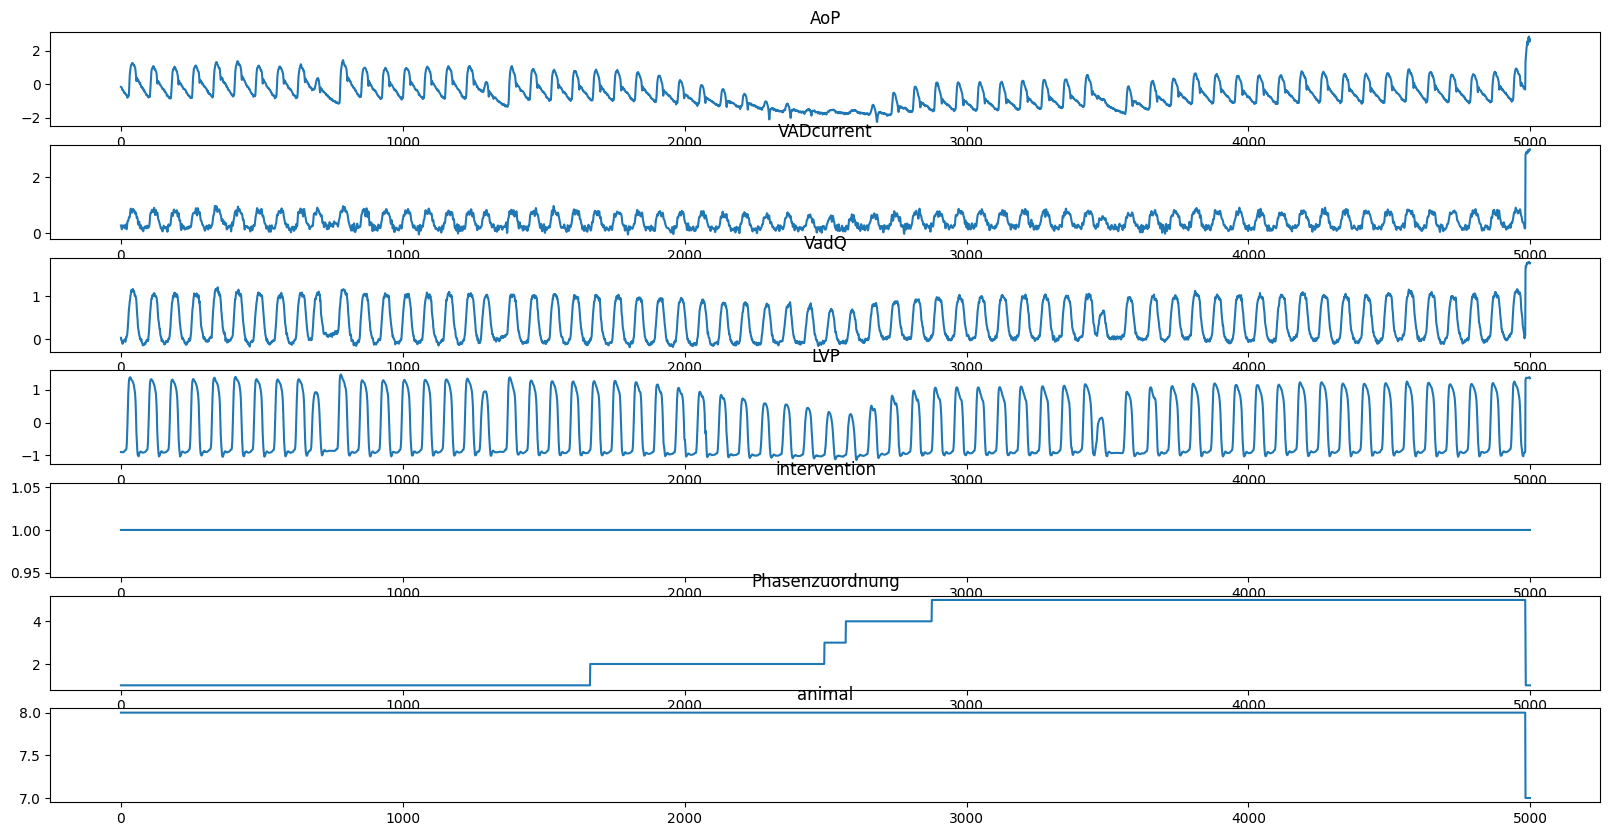

In [10]:
df_IPA = df[['intervention', 'Phasenzuordnung', 'animal']]

# split df into separate dataframes for each animal
scaler = StandardScaler()
df_temp = pd.DataFrame()

#utils.visualize(df, [SIG_A, SIG_B, SIG_C, SIG_D, 'intervention', 'animal'], 72094)

for animal in df['animal'].unique():
    # split df into separate dataframes for each animal
    df_animal = df.loc[df['animal'] == animal]
    df_animal = normalize_by_phase1(df_animal, scaler)
    # append df_animal to df_temp
    df_temp = pd.concat([df_temp, df_animal], axis=0, ignore_index=True)

print(df.shape)
print(df_temp.shape)
df = df_temp
df = df.drop(columns=['intervention', 'Phasenzuordnung', 'animal'])
df.dropna(inplace=True) # why do I have to do it again?
df = df.join(df_IPA)
utils.visualize(df, [SIG_A, SIG_B, SIG_C, SIG_D, 'intervention', 'Phasenzuordnung', 'animal'], 5000)

In [11]:
# group by animal size in percent
df_grouped = df.groupby('animal').size().reset_index(name='counts')
df_grouped['counts'] = df_grouped['counts'] / df_grouped['counts'].sum() * 100
df_grouped

,animal,counts
0,1.0,2.726102
1,2.0,2.404822
2,3.0,5.725719
3,4.0,5.274457
4,5.0,1.007303
5,7.0,7.727310
6,8.0,5.407767
7,9.0,2.284188
8,10.0,17.845819
9,11.0,7.476085


In [12]:

# pick 1 random animals for test data
test_animals = df['animal'].sample(n=1, random_state=42).unique()

all_animals = df['animal'].unique()
# remove test animals from train animals
train_animals =  [x for x in all_animals if x not in test_animals]

print('\nTest animal(s):', test_animals)
# test data
df_test = df[df['animal'].isin(test_animals)]

# train dataframe with only animals from train_animals
df_train = df[df['animal'].isin(train_animals)]
print('\nDifferent animal IDs after removing those that are in the test dataset: ',len(df_train['animal'].unique()))


print('\nTrain data shape:', df_train.shape)
print('\nTest data shape:', df_test.shape)

# lengt of df_train
print('\nThe test dataset is {} percent of the whole data: '.format((len(df_test)/(len(df_train) + len(df_test))) * 100))


Test animal(s): [20.]

Different animal IDs after removing those that are in the test dataset:  21

Train data shape: (3640850, 13)

Test data shape: (477433, 13)

The test dataset is 11.593010970834204 percent of the whole data: 


In [13]:
if SKIPCONNECTIONS: # we always use embeddings
    gen_B = EmbeddingUnetGenerator(INPUTCHANNELS = CHANNELS, OUTPUTCHANNELS = 1).to(DEVICE)
    gen_A = EmbeddingUnetGenerator(INPUTCHANNELS = 1, OUTPUTCHANNELS = CHANNELS).to(DEVICE)

if not SKIPCONNECTIONS:
    gen_B = EmbeddingEncoderDecoderGenerator(INPUTCHANNELS = CHANNELS, OUTPUTCHANNELS = 1).to(DEVICE)
    gen_A = EmbeddingEncoderDecoderGenerator(INPUTCHANNELS = 1, OUTPUTCHANNELS = CHANNELS).to(DEVICE)

disc_B = MultiChannelDiscriminator(CHANNELS = 1).to(DEVICE)
disc_A = MultiChannelDiscriminator(CHANNELS = CHANNELS).to(DEVICE)

# optimizers for discriminator and generator 
opt_disc = torch.optim.AdamW(                                         
    list(disc_A.parameters()) + list(disc_B.parameters()), 
    lr=LEARNING_RATE, 
)
opt_gen = torch.optim.AdamW(
    list(gen_A.parameters()) + list(gen_B.parameters()),
    lr=LEARNING_RATE,
)

# maybe a step learning rate would be a good idea 1e-4 -> 1e-5
# scheduler
gen_scheduler = torch.optim.lr_scheduler.PolynomialLR(optimizer = opt_gen,
                                                      total_iters = NUM_EPOCHS-LR_DECAY_AFTER_EPOCH, 
                                                      power = 1,
                                                    )
disc_scheduler = torch.optim.lr_scheduler.PolynomialLR(optimizer = opt_disc,
                                                       total_iters = NUM_EPOCHS-LR_DECAY_AFTER_EPOCH, 
                                                       power = 1,
                                                    )
# losses
l1 = nn.L1Loss() 
mse = nn.MSELoss() 

# create datasets
train_dataset = AnimalDatasetEmbedding(df_train, source_signals, target_name = TARGET, test = False, window_length = WINDOW)
test_dataset = AnimalDatasetEmbedding(df_test, source_signals, target_name = TARGET, test = True, window_length = WINDOW)
gen_dataset = AnimalDatasetEmbedding(df_test, source_signals, target_name = TARGET, test = False, window_length = WINDOW)


# Data loader
loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True,)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True,)
gen_loader = DataLoader(gen_dataset, batch_size=1, shuffle=True, pin_memory=True,)

# run in float16
g_scaler = torch.cuda.amp.GradScaler()
d_scaler = torch.cuda.amp.GradScaler()

In [19]:
import wandb

# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="Cycle_GAN",
    
    # track hyperparameters and run metadata
    config={
    "learning_rate": LEARNING_RATE,
    "epochs": NUM_EPOCHS,
    }
)

Test/Adversarial or GAN loss A,▁▂▆▅▇▇█▇
Test/Adversarial or GAN loss B,▁▄▇▇████
Test/Cycle consistency loss A,█▃▃▂▂▂▂▁
Test/Cycle consistency loss B,█▁▂▁▁▁▁▁
Test/Discriminator A loss,█▄▂▃▂▂▁▂
Test/Discriminator B loss,█▃▁▁▁▁▁▁
Test/Discriminator loss,█▄▁▂▁▁▁▁
Test/Epoch,▁▂▃▄▅▆▇█
Test/Generator loss,▁▂▆▇▇▇█▇
Test/L1 loss between real signal A and fake signals A,▁▂▅█▆▇█▇
Test/L1 loss between real signal B and fake signals B,▃▆█▆▄▁▃▁


In [20]:
def discriminator_loss(disc, reals, fakes):
    # calculate how close reals are to being classified as real
    real_loss = mse(disc(reals), torch.ones_like(disc(reals)))
    # calculate how close fakes are to being classified as fake
    fake_loss = mse(disc(fakes), torch.zeros_like(disc(fakes)))
    # return the average of real and fake loss
    return (real_loss + fake_loss) / 2


@torch.cuda.amp.autocast()
def get_disc_loss(sig_A, sig_B, phase, intervention, 
                    disc_A, disc_B, gen_A, gen_B, fake_A, fake_B
                    ):
    """
    Return the loss of the discriminator given inputs.
    """
    # generate fakes
    # with torch.no_grad():
    #     fake_B = gen_B(sig_A, phase, intervention).detach()
    #     fake_A = gen_A(sig_B, phase, intervention).detach()
    
    # discriminator loss
    disc_B_loss = discriminator_loss(disc_B, sig_B, fake_B)
    disc_A_loss = discriminator_loss(disc_A, sig_A, fake_A)
    disc_loss = (disc_A_loss + disc_B_loss) / 2

    return disc_loss, disc_A_loss, disc_B_loss

@torch.cuda.amp.autocast()
def calc_gen_loss(sig_A, sig_B, phase, intervention,
                  gen_A, gen_B, disc_A, disc_B, fake_B, fake_A
                  ):
    loss = 0

    if GAN_LOSS:
        g_A_loss = l1(disc_A(fake_A), torch.ones_like(disc_A(fake_A))) 
        g_B_loss = l1(disc_B(fake_B), torch.ones_like(disc_B(fake_B))) 

        loss += g_A_loss * LAMBDA_GAN + g_B_loss * LAMBDA_GAN
    else:
        g_A_loss = torch.tensor(0)
        g_B_loss = torch.tensor(0)

    if CYCLE:
        rec_B = gen_B(fake_A, phase, intervention)
        rec_A = gen_A(fake_B, phase, intervention)
        cycle_B_loss = l1(sig_B, rec_B)  # l1 loss: Mean absolute error between each element in the input x and target y
        cycle_A_loss = l1(sig_A, rec_A)  # l1 loss in cycle GAN paper

        loss += cycle_B_loss * LAMBDA_CYCLE + cycle_A_loss * LAMBDA_CYCLE
    else:
        cycle_B_loss = torch.tensor(0)
        cycle_A_loss = torch.tensor(0)

    if SUPERVISED:
        sup_A_loss = l1(sig_A, fake_A)
        sup_B_loss = l1(sig_B, fake_B)

        loss += sup_A_loss * LAMBDA_SUPERVISED + sup_B_loss * LAMBDA_SUPERVISED
    else:
        sup_A_loss = torch.tensor(0)
        sup_B_loss = torch.tensor(0)

    if IDENTITY:
        id_B_loss = l1(sig_B, gen_B(sig_B, phase, intervention))
        id_A_loss = l1(sig_A, gen_A(sig_A, phase, intervention))

        loss += id_B_loss * LAMBDA_IDENTITY + id_A_loss * LAMBDA_IDENTITY
    else:
        id_B_loss = torch.tensor(0)
        id_A_loss = torch.tensor(0)

    return loss, g_A_loss, g_B_loss, cycle_B_loss, cycle_A_loss, id_B_loss, id_A_loss, sup_A_loss, sup_B_loss

## Training

In [21]:
# training loop
from tqdm.auto import tqdm

for epoch in tqdm(range(NUM_EPOCHS)):

    for source, target, phase, intervention in loader:
        # convert to float16
        source = source.float() # neccessary to prevent error: "Input type (torch.cuda.DoubleTensor) 
        target = target.float() # and weight type (torch.cuda.HalfTensor) should be the same"
    
        # move to GPU
        source = source.to(DEVICE)
        target = target.to(DEVICE)
        phase = phase.to(DEVICE)
        intervention = intervention.to(DEVICE)

        #  ------------------------------- #
        #  ----- train discriminators ---- #
        #  ------------------------------- #
        with torch.no_grad():
            fake_target = gen_B(source, phase, intervention).detach()
            fake_source = gen_A(target, phase, intervention).detach()

        d_loss, disc_A_loss, disc_B_loss = get_disc_loss(source, target, phase, intervention,
                                                            disc_A, disc_B, gen_A, gen_B, 
                                                            fake_source, fake_target
                                                        )

        # update gradients of discriminator 
        opt_disc.zero_grad() 
        d_scaler.scale(d_loss).backward()  
        d_scaler.step(opt_disc)  
        d_scaler.update()
        

        # -------------------------------- #
        # ------- train generators ------- #
        # -------------------------------- # 

        out = calc_gen_loss(source, target, phase, intervention,
                                gen_A, gen_B, disc_A, disc_B, 
                                fake_target, fake_source
                                )
        g_loss, g_A_loss, g_B_loss, cycle_B_loss, cycle_A_loss, id_B_loss, id_A_loss, sup_A_loss, sup_B_loss = out

        # update gradients of generator
        opt_gen.zero_grad()
        g_scaler.scale(g_loss).backward() 
        g_scaler.step(opt_gen) 
        g_scaler.update()

    wandb.log({'Train/Discriminator A loss': disc_A_loss.item(),
                'Train/Discriminator B loss': disc_B_loss.item(),
                'Train/Total Discriminator loss': d_loss.item(),
                'Train/Total Generator loss': g_loss.item(),
                'Train/Adversarial loss A': g_A_loss.item(),
                'Train/Adversarial loss B': g_B_loss.item(),
                'Train/Cycle consistency loss A': cycle_A_loss.item(),
                'Train/Cycle consistency loss B': cycle_B_loss.item(),
                'Train/Supervised loss A': sup_A_loss.item(),
                'Train/Supervised loss B': sup_B_loss.item(),
                # 'Train/Identity loss A': id_A_loss.item(),
                # 'Train/Identity loss B': id_B_loss.item()
                })
        

    # ------------------------ #
    # ------ Validation ------ #
    # ------------------------ #

    if (epoch+1) % 50 == 0:

        with torch.no_grad():
            # set models to evaluation mode
            disc_A.eval()  # set discriminator to evaluation mode
            disc_B.eval()  # turns off Dropouts Layers, BatchNorm Layers etc
            gen_B.eval()
            gen_A.eval()

            for source, target, phase, intervention in test_loader:
                # convert to float16
                source = source.float()
                target = target.float()

                # move to GPU
                source = source.to(DEVICE)
                target = target.to(DEVICE)
                phase = phase.to(DEVICE)
                intervention = intervention.to(DEVICE)

                fake_target = gen_B(source, phase, intervention).detach() # already torch.no_grad()
                fake_source = gen_A(target, phase, intervention).detach()

                # calculate l1 loss of fake signals and real signals
                test_real_fake_lossB= l1(target, fake_target)   # l1(sig_B, fake_B)
                test_real_fake_lossA = l1(source, fake_source)

                #  ------------------------------- #
                #  ----- test discriminators ----- #
                #  ------------------------------- #

                test_d_loss, test_disc_A_loss, test_disc_B_loss = get_disc_loss(source, target, phase, intervention,
                                                                    disc_A, disc_B, gen_A, gen_B, 
                                                                    fake_source, fake_target
                                                                )
                
                # -------------------------------- #
                # ------- test generators -------- #
                # -------------------------------- # 

                out = calc_gen_loss(source, target, phase, intervention,
                                        gen_A, gen_B, disc_A, disc_B, 
                                        fake_target, fake_source
                                        )
                g_lossT, g_A_lossT, g_B_lossT, cycle_B_lossT, cycle_A_lossT, id_B_lossT, id_A_lossT, sup_A_lossT, sup_B_lossT = out

            wandb.log({'Test/Generator loss': g_lossT.item(),
                        'Test/Discriminator loss': test_d_loss.item(),
                        'Test/L1 loss between real signal A and fake signals A': test_real_fake_lossA.item(),
                        'Test/L1 loss between real signal B and fake signals B': test_real_fake_lossB.item(),
                        'Test/Discriminator A loss': test_disc_A_loss.item(),
                        'Test/Discriminator B loss': test_disc_B_loss.item(),
                        'Test/Adversarial or GAN loss A': g_A_lossT.item(),
                        'Test/Adversarial or GAN loss B': g_B_lossT.item(),
                        'Test/Cycle consistency loss A': cycle_A_lossT.item(),
                        'Test/Cycle consistency loss B': cycle_B_lossT.item(),
                        'Test/Supervised loss A': sup_A_lossT.item(),
                        'Test/Supervised loss B': sup_B_lossT.item(),
                        'Test/Epoch': epoch+1,
                })

100%|██████████| 400/400 [1:03:38<00:00,  9.55s/it]


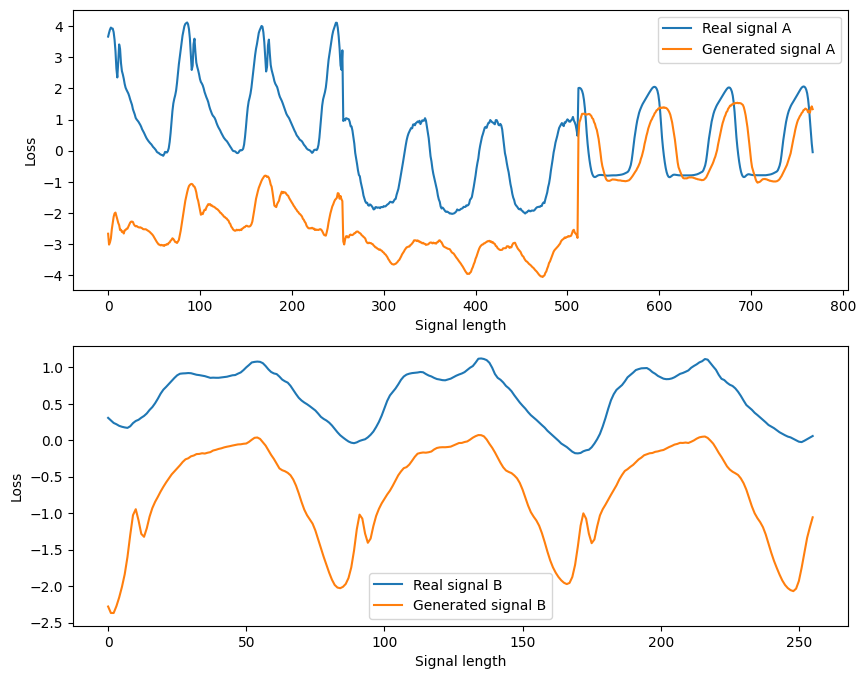

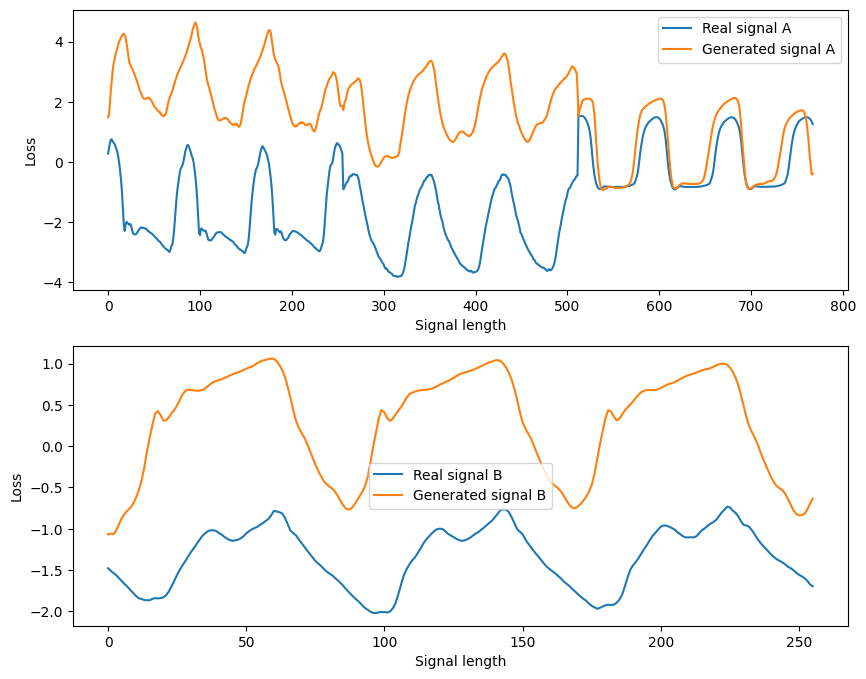

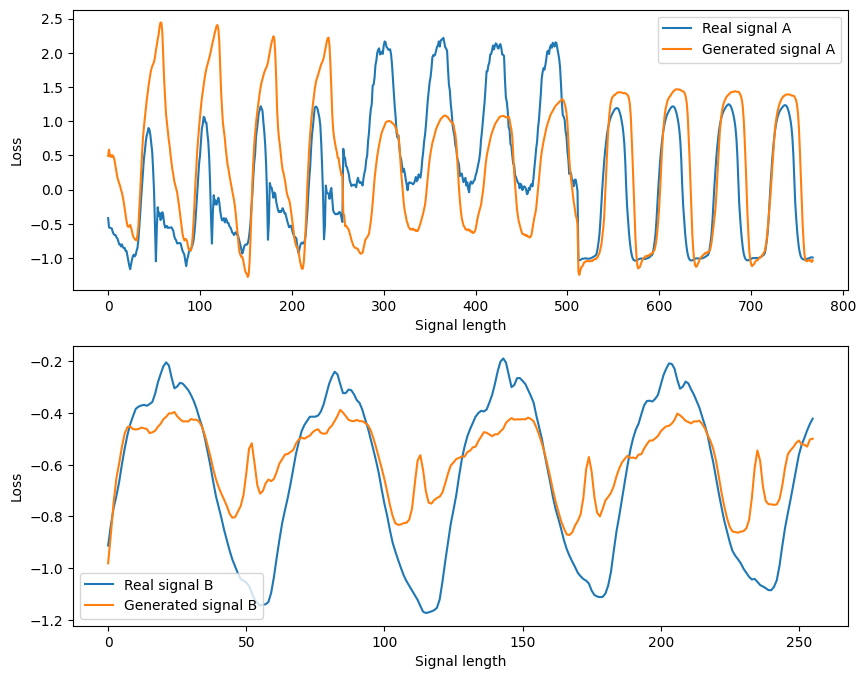

In [22]:
# Generate signals
idx = 0             
phases = df['Phasenzuordnung'].unique()
for source, target, phase, intervention in gen_loader:
    if idx == 3:
        break                 
                    
    source = source.float()
    target = target.float()
    source = source.to(DEVICE)
    target = target.to(DEVICE)
    phase = phase.to(DEVICE)
    intervention = intervention.to(DEVICE)

    fake_target = gen_B(source, phase, intervention)
    fake_source = gen_A(target, phase, intervention)

                        
    fake_target = fake_target.reshape(-1)
    fake_source = fake_source.reshape(-1)
    source = source.reshape(-1)
    target = target.reshape(-1)

    fig, ax = plt.subplots(2, 1, figsize=(10, 8))
    ax[0].plot(source.cpu().detach().numpy(), label= 'Real signal A')
    ax[0].plot(fake_source.cpu().detach().numpy(), label= 'Generated signal A')
    ax[0].set_xlabel('Signal length')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    ax[1].plot(target.cpu().detach().numpy(), label= 'Real signal B')
    ax[1].plot(fake_target.cpu().detach().numpy(), label= 'Generated signal B')
    ax[1].set_xlabel('Signal length')
    ax[1].set_ylabel('Loss')
    ax[1].legend()

    idx += 1       